In [2]:
import torch
import matplotlib.pyplot as plt
import gym
import numpy as np
from scipy.signal import savgol_filter
import seaborn as sns
import pandas as pd

from REINFORCE import MCPGAgent

In [3]:
# initialize environment
env = gym.make('LunarLander-v2')
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

# set seed
seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# hyperparameters
episodes = 500 # run agent for this many episodes
hidden_size = 256 # number of units in NN hidden layers
actor_lr = 0.002 # learning rate for actor
value_function_lr = 0.002 # learning rate for value function
discount = 0.99 # discount factor gamma value
reward_scale = 0.01 #scale reward by this amount

# create agent
agent = MCPGAgent(state_size, 
                action_size, 
                actor_lr, 
                value_function_lr, 
                discount,
                hidden_size)
        

In [4]:
stats_rewards_list = [] # store stats for plotting in this
stats_every = 10 # print stats every this many episodes
total_reward = 0
timesteps = 0
episode_length = 0
stats_actor_loss, stats_vf_loss = 0., 0.

for ep in range(episodes):
    state = env.reset()
    state_list, action_list, reward_list = [], [], []
    
    # stopping condition for training if agent reaches the amount of reward
    if len(stats_rewards_list) > stats_every and np.mean(stats_rewards_list[-stats_every:],axis=0)[1] > 190:
        print("Stopping at episode {} with average rewards of {} in last {} episodes".
            format(ep, np.mean(stats_rewards_list[-stats_every:],axis=0)[1], stats_every))
        break  
    
    state_list = []
    action_list = []
    reward_list = []
    
    # train in each episode until episode is done
    while True:
        timesteps += 1
        #env.render()

        # select an action from the agent's policy
        action = agent.act(state)
        
        # enter action into the env
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        episode_length += 1

        # store agent's trajectory
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward*reward_scale)
        
        # end episode early
        if total_reward < -250:
            done = 1
        
        if done:
            actor_loss, vf_loss = agent.train(state_list, action_list, reward_list)
            stats_rewards_list.append((ep, total_reward, episode_length))
            stats_actor_loss += actor_loss
            stats_vf_loss += vf_loss
            total_reward = 0
            episode_length = 0  
            if ep % stats_every == 0:
                print('Episode: {}'.format(ep),
                    'Timestep: {}'.format(timesteps),
                    'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
                    'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
                    'Actor Loss: {:.4f}'.format(stats_actor_loss/stats_every), 
                    'VF Loss: {:.4f}'.format(stats_vf_loss/stats_every))
                stats_actor_loss, stats_vf_loss = 0., 0.
            break
        
        state = next_state

/Users/riccardo/Documents/GitHub/Lunar_Lander_DeepRL/Discrete/PG_MC_REINFORCE/REINFORCE.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.FloatTensor(states).to(device)


Episode: 0 Timestep: 82 Total reward: -258.5 Episode length: 82.0 Actor Loss: -0.1943 VF Loss: 0.2034
Episode: 10 Timestep: 1135 Total reward: -247.5 Episode length: 105.3 Actor Loss: -0.0022 VF Loss: 0.2994
Episode: 20 Timestep: 2464 Total reward: -263.4 Episode length: 132.9 Actor Loss: -0.1933 VF Loss: 0.3242
Episode: 30 Timestep: 3814 Total reward: -210.3 Episode length: 135.0 Actor Loss: 0.3468 VF Loss: 0.3873
Episode: 40 Timestep: 5091 Total reward: -151.5 Episode length: 127.7 Actor Loss: -0.0134 VF Loss: 0.2722
Episode: 50 Timestep: 6100 Total reward: -135.4 Episode length: 100.9 Actor Loss: -0.3675 VF Loss: 0.2351
Episode: 60 Timestep: 7089 Total reward: -105.9 Episode length: 98.9 Actor Loss: 0.1166 VF Loss: 0.1185
Episode: 70 Timestep: 8091 Total reward: -108.8 Episode length: 100.2 Actor Loss: 0.1382 VF Loss: 0.1922
Episode: 80 Timestep: 8994 Total reward: -94.5 Episode length: 90.3 Actor Loss: -0.1114 VF Loss: 0.0977
Episode: 90 Timestep: 9860 Total reward: -106.7 Episode 

/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/riccardo/opt/anaconda3/envs/main/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

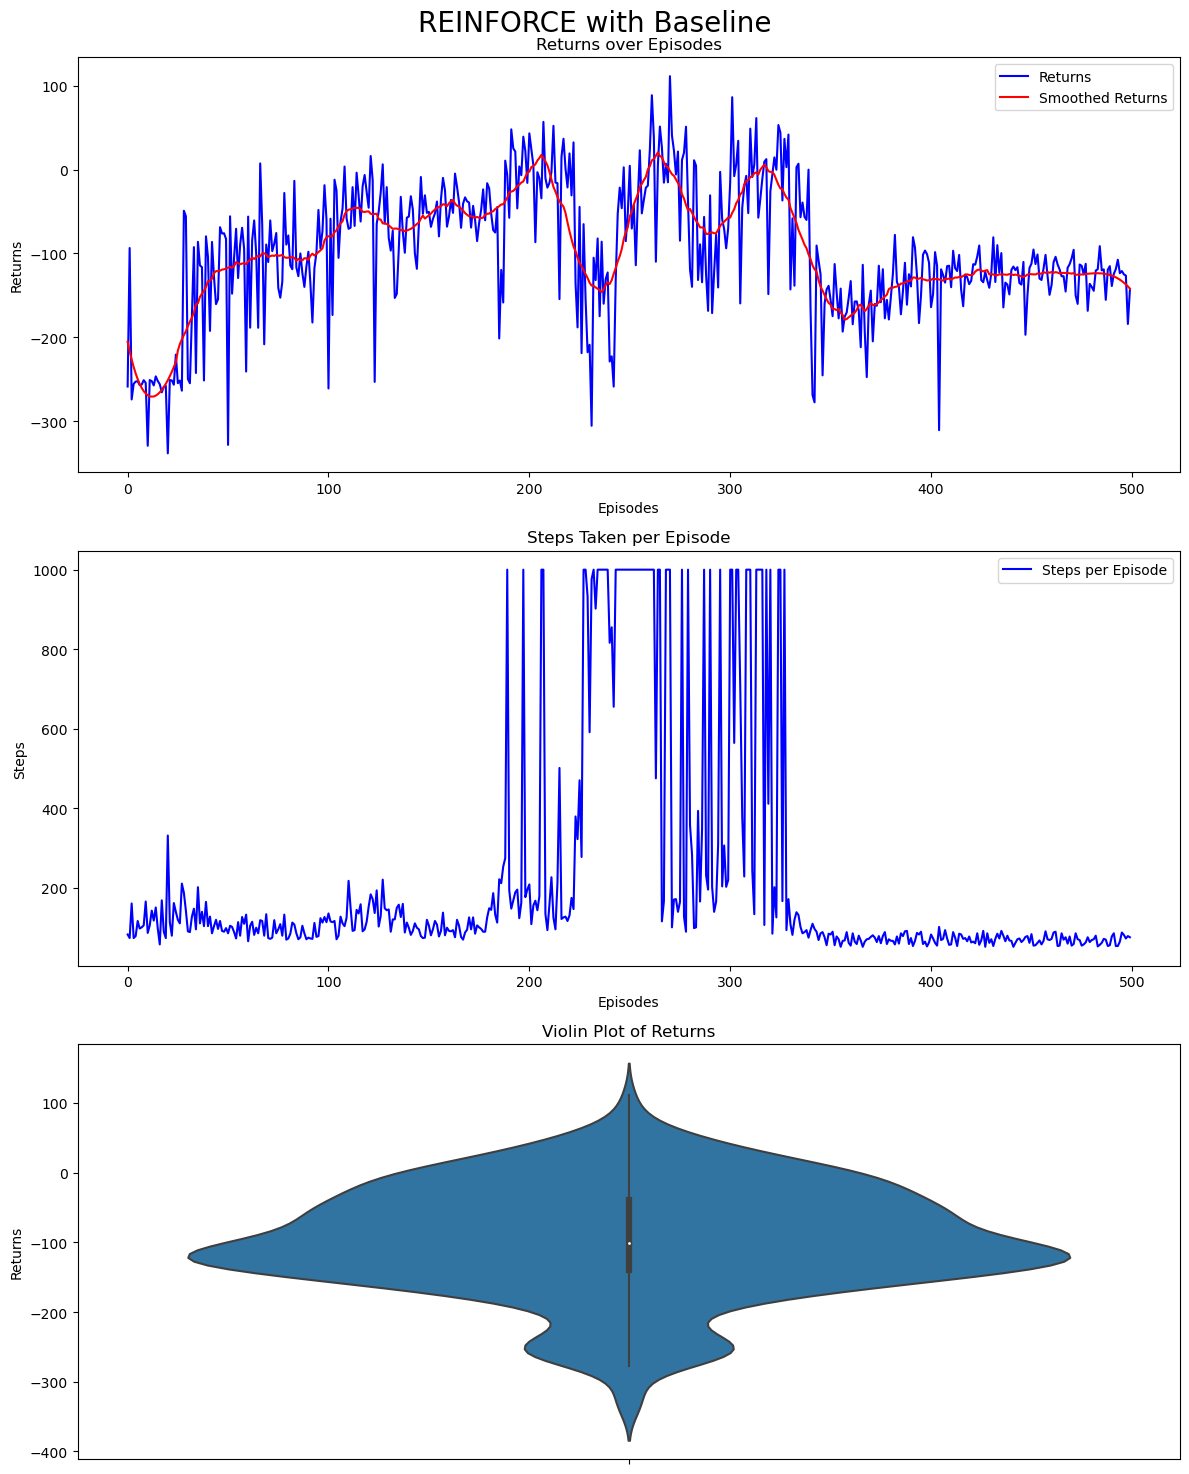

In [7]:
# plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0)) 
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, returns, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(reward, 10)
cum_l = get_running_stat(l, 10)


# Determine the window length based on the size of the data
window_length = min(50, len(returns))

# Apply Savitzky-Golay filter
smoothed_returns = savgol_filter(returns, window_length=window_length, polyorder=3)
# MA = pd.Series(returns).rolling(window=100).mean()

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

# Plot returns and smoothed returns
sns.lineplot(data=returns, label='Returns', color='blue', ax=axs[0])
sns.lineplot(data=smoothed_returns, label='Smoothed Returns', color='red', ax=axs[0])
# sns.lineplot(data=MA, label='Smoothed Returns', color='red', ax=axs[0])
axs[0].set_ylabel('Returns')
axs[0].set_xlabel('Episodes')
axs[0].set_title('Returns over Episodes')
axs[0].legend()

# Plot steps taken per episode
sns.lineplot(x=episode, y=l, label='Steps per Episode', color='blue', ax=axs[1])
axs[1].set_ylabel('Steps')
axs[1].set_xlabel('Episodes')
axs[1].set_title('Steps Taken per Episode')
axs[1].legend()

# Plot violin plot of returns
sns.violinplot(y=returns, ax=axs[2])
axs[2].set_ylabel('Returns')
axs[2].set_title('Violin Plot of Returns')

plt.suptitle('REINFORCE with Baseline', fontsize=20)
plt.tight_layout()
plt.show()

In [6]:
# save the actor and value function networks
torch.save(agent.actor_net.state_dict(), 'Trained_Agents/MC_actor.pth')
torch.save(agent.vf_net.state_dict(), 'Trained_Agents/MC_valueF.pth')